In [1]:
from pyspark.sql import SparkSession
import requests
from io import BytesIO
from zipfile import ZipFile
from neo4j_parallel_spark_loader.monopartite import group_and_batch_spark_dataframe
from neo4j_parallel_spark_loader import ingest_spark_dataframe
from neo4j_parallel_spark_loader.visualize import create_ingest_heatmap

## Create spark session
Update the values below for your environment

In [2]:
username = "NEO4J_USER"
password = "NEO4J_PASSWORD"
url = "NEO4J_URL"
dbname = "NEO4J_DATABASE"
spark_executor_count=5

spark = (
    SparkSession.builder
    .appName("TwitchGamers")
    .config("neo4j.url", url)
    .config("url", url)
    .config("neo4j.authentication.basic.username", username)
    .config("neo4j.authentication.basic.password", password)
    .config("neo4j.database", dbname)
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/12 09:48:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Download data

In [3]:
# Download the ZIP file
response = requests.get("https://snap.stanford.edu/data/twitch_gamers.zip")
zip_file = ZipFile(BytesIO(response.content))

# Read the CSV file directly from the ZIP
with zip_file.open("large_twitch_edges.csv") as file:
    # Convert to string buffer for Spark to read
    content = file.read().decode('utf-8')
    
    # Create RDD from content
    rdd = spark.sparkContext.parallelize(content.splitlines())
    
    # Convert RDD to DataFrame
    twitch_df = spark.read.csv(rdd, header=True)

# Now df is your Spark DataFrame containing the data
# You can verify the data
twitch_df.show()
twitch_df.printSchema()

25/01/12 09:48:34 WARN TaskSetManager: Stage 0 contains a task of very large size (12201 KiB). The maximum recommended task size is 1000 KiB.
25/01/12 09:48:39 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 0 (TID 0): Attempting to kill Python Worker
25/01/12 09:48:40 WARN TaskSetManager: Stage 1 contains a task of very large size (12201 KiB). The maximum recommended task size is 1000 KiB.


+------------+------------+
|numeric_id_1|numeric_id_2|
+------------+------------+
|       98343|      141493|
|       98343|       58736|
|       98343|      140703|
|       98343|      151401|
|       98343|      157118|
|       98343|      125430|
|       98343|        3635|
|       98343|         495|
|       98343|      116648|
|       98343|        1679|
|       98343|      123861|
|       98343|       89631|
|       98343|      113417|
|       98343|      145281|
|       98343|       10408|
|       98343|        3181|
|       98343|       40675|
|       98343|       95914|
|       98343|      155127|
|       98343|      124827|
+------------+------------+
only showing top 20 rows

root
 |-- numeric_id_1: string (nullable = true)
 |-- numeric_id_2: string (nullable = true)



25/01/12 09:48:44 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 1 (TID 1): Attempting to kill Python Worker


In [4]:
twitch_df.count()

25/01/12 09:48:44 WARN TaskSetManager: Stage 2 contains a task of very large size (12201 KiB). The maximum recommended task size is 1000 KiB.


6797557

## Load nodes

In [ ]:
node_df = (twitch_df
            .select('numeric_id_1')
            .withColumnRenamed('numeric_id_1', 'nodeId')
            .union(
                twitch_df
                .select('numeric_id_2')
                .withColumnRenamed('numeric_id_2', 'nodeId'))
                .dropDuplicates())
node_df.count()

In [ ]:
(
    node_df.write
    .format("org.neo4j.spark.DataSource")
    .mode("Overwrite")
    .option("labels", ":Node")
    .option("node.keys", "nodeId:id")
    .option("schema.optimization.node.keys", "KEY")
    .save()
)

## Load rels

In [5]:
rel_batch_df = group_and_batch_spark_dataframe(spark_dataframe=twitch_df, 
                                               source_col='numeric_id_1', 
                                               target_col='numeric_id_2', 
                                               num_groups=(2 * spark_executor_count)-1)

25/01/12 09:48:52 WARN TaskSetManager: Stage 5 contains a task of very large size (12201 KiB). The maximum recommended task size is 1000 KiB.
25/01/12 09:49:23 WARN TaskSetManager: Stage 13 contains a task of very large size (12201 KiB). The maximum recommended task size is 1000 KiB.


In [6]:
rel_batch_df.show()

25/01/12 09:49:44 WARN TaskSetManager: Stage 29 contains a task of very large size (12201 KiB). The maximum recommended task size is 1000 KiB.
25/01/12 09:49:48 WARN PythonRunner: Detected deadlock while completing task 5.0 in stage 29 (TID 87): Attempting to kill Python Worker
25/01/12 09:49:48 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 29 (TID 82): Attempting to kill Python Worker
25/01/12 09:49:48 WARN PythonRunner: Detected deadlock while completing task 1.0 in stage 29 (TID 83): Attempting to kill Python Worker
25/01/12 09:49:48 WARN PythonRunner: Detected deadlock while completing task 6.0 in stage 29 (TID 88): Attempting to kill Python Worker
25/01/12 09:49:48 WARN PythonRunner: Detected deadlock while completing task 2.0 in stage 29 (TID 84): Attempting to kill Python Worker
25/01/12 09:49:48 WARN PythonRunner: Detected deadlock while completing task 3.0 in stage 29 (TID 85): Attempting to kill Python Worker
25/01/12 09:49:48 WARN PythonRunner: Dete

+------------+------------+------+-----+
|numeric_id_1|numeric_id_2| group|batch|
+------------+------------+------+-----+
|      132936|       55282|5 -- 7|    6|
|      132936|       52228|1 -- 7|    4|
|      132936|       87835|6 -- 7|    2|
|      132936|       91750|7 -- 8|    3|
|      132936|       23194|3 -- 7|    5|
|      132936|       76703|2 -- 7|    0|
|      132936|        7938|7 -- 8|    3|
|      132936|      150412|7 -- 7|    7|
|      132936|        2158|5 -- 7|    6|
|      132936|       90372|7 -- 8|    3|
|      132936|      165616|4 -- 7|    1|
|      132936|      108001|7 -- 8|    3|
|      132936|       55253|7 -- 7|    7|
|      132936|      156774|7 -- 7|    7|
|      132936|      155380|2 -- 7|    0|
|      132936|      109338|6 -- 7|    2|
|      132936|       65772|6 -- 7|    2|
|      132936|      161490|0 -- 7|    8|
|      132936|       93083|4 -- 7|    1|
|      132936|       53374|7 -- 8|    3|
+------------+------------+------+-----+
only showing top

25/01/12 09:49:51 WARN TaskSetManager: Stage 37 contains a task of very large size (12201 KiB). The maximum recommended task size is 1000 KiB.


<Axes: title={'center': 'Parallel Ingest Heat Map'}, xlabel='Group Number', ylabel='Batch'>

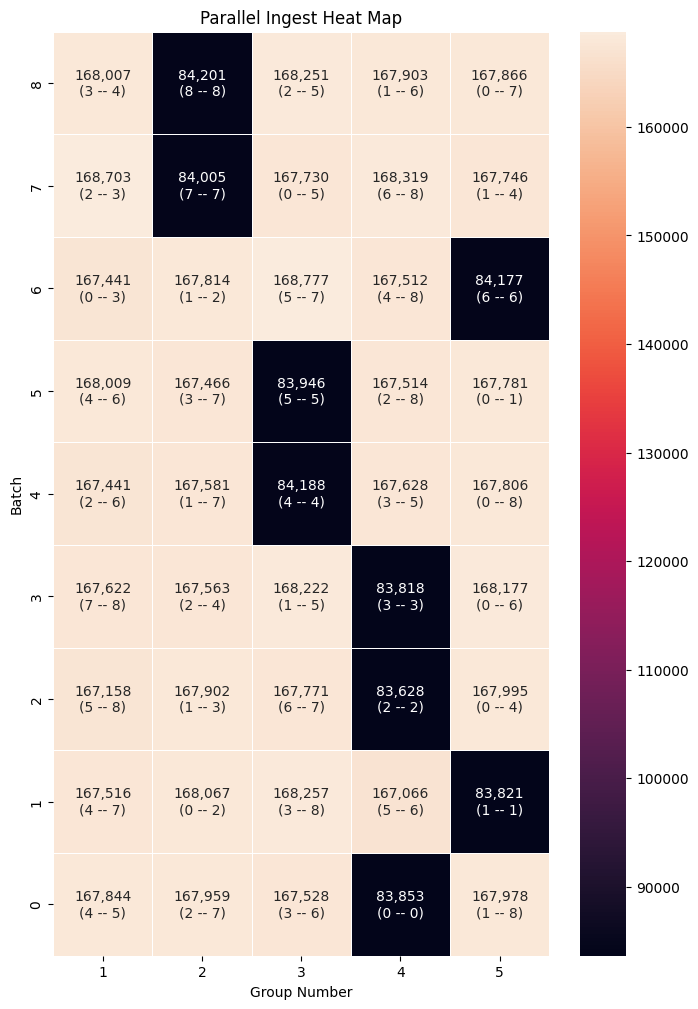

In [7]:
create_ingest_heatmap(rel_batch_df)

In [ ]:
query = """
    MATCH(source:Node {id: event.numeric_id_1})
    MATCH(target:Node {id: event.numeric_id_2})
    MERGE(source)-[r:RELATES_TO]->(target)
    """

ingest_spark_dataframe(
    spark_dataframe=rel_batch_df,
    save_mode= "Overwrite",
    options={"query":query}
)

## Delete rels

In [ ]:
rel_count = twitch_df.count()
batch_count = rel_count // 10000 + 1
print(rel_count, batch_count)

In [ ]:
from pyspark.sql.functions import lit
del_df = (spark.range(batch_count)
    .select(lit(1).alias("id")))
print(del_df.count())

In [ ]:
del_query = "MATCH ()-[r:RELATES_TO]->() WITH r LIMIT 10000 DELETE r"

(
    del_df.coalesce(1).write
    .format("org.neo4j.spark.DataSource")
    .mode("Overwrite")
    .option("query", del_query)
    .option("batch.size", 1)
    .save()
)

## Load rels serially

In [ ]:
(
    twitch_df.coalesce(1).write
    .format("org.neo4j.spark.DataSource")
    .mode("Overwrite")
    .option("query", query)
    .save()
)